In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
import joblib


In [2]:
import os 
import sys

In [3]:
sys.path.append(os.path.abspath('../scripts'))

In [4]:
from data_cleaning import load_data,clean_data,add_geolocation,create_features,preprocess_data

In [5]:
fraud_df=pd.read_csv('../Data/Fraud_Data.csv')
ip_df = pd.read_csv('../Data/IpAddress_to_Country.csv')
fraud_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0


In [6]:
value_count = fraud_df['class'].value_counts(normalize=True) * 100
print(f'Non fraud data: {value_count[0]:.2f}%')
print(f'Fraud data: {value_count[1]:.2f}%')

Non fraud data: 90.64%
Fraud data: 9.36%


In [7]:
ip_df

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [8]:
# Ensure 'source' column is present in the dataframe
if 'source' in fraud_df.columns:
	gp = fraud_df.groupby('source')
	display(gp.get_group('SEO').set_index('signup_time').head())
else:
	print("The 'source' column is not present in the dataframe.")

,user_id,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
signup_time,,,,,,,,,,
2015-02-24 22:55:49,22058,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
2015-01-01 18:52:44,1359,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
2015-04-28 21:13:25,150084,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
2015-04-21 23:38:34,159045,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
2015-06-16 21:19:35,79203,2015-06-21 03:29:59,18,IBPNKSMCKUZWD,SEO,Safari,M,33,4.161541e+09,0


In [9]:
# Calculate fraud rates per source
fraud_rates = fraud_df.groupby('source')['class'].mean().rename('source_fraud_rate')

# Add as a new column to the original DataFrame
fraud_df = fraud_df.merge(fraud_rates, left_on='source', right_index=True)

In [10]:
# 1. Calculate fraud rates per source
fraud_rates = fraud_df.groupby('source')['class'].mean()

# 2. Merge into original data
#fraud_df = fraud_df.merge(fraud_rates.rename('source_fraud_rate'), on='source')

# 3. Train a model using `source_fraud_rate` as a feature
from sklearn.ensemble import RandomForestClassifier
X = fraud_df[['source_fraud_rate', 'purchase_value', 'age']]
y = fraud_df['class']
model = RandomForestClassifier().fit(X, y)


In [11]:
# Create graph_df with rolling means
graph_df = fraud_df.set_index('signup_time').groupby('ip_address')['purchase_value'].rolling(window=7).mean().reset_index()
graph_df.rename(columns={'purchase_value': 'purchase_value_rolling_mean'}, inplace=True)

# Merge rolling means from graph_df (assuming signup_time and ip_address are keys)
fraud_df = fraud_df.merge(
    graph_df,  # Ensure signup_time and ip_address are columns
    on=['signup_time', 'ip_address'],  # Adjust based on your actual columns
    how='left'
)

# Already merged source_fraud_rate earlier – ensure it's included!
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,source_fraud_rate,purchase_value_rolling_mean
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,0.089285,NaN
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,0.092066,NaN
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,0.089285,NaN
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0.089285,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,0.092066,NaN


In [12]:
cleaned_df=clean_data(fraud_df)
cleaned_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,source_fraud_rate,purchase_value_rolling_mean
24695,51249,2015-01-09 04:26:33,2015-01-09 04:26:34,29,CJWVPNPXURMXB,SEO,Safari,M,30,2.804811e+09,1,0.089285,29.0
25768,322924,2015-01-01 11:32:46,2015-01-01 11:32:47,23,HGVNRPOHIBZLJ,Direct,Chrome,M,42,1.235453e+09,1,0.105370,23.0
27888,277313,2015-01-03 13:10:45,2015-01-03 13:10:46,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,0.089285,42.0
28993,352849,2015-01-01 11:32:41,2015-01-01 11:32:42,23,HGVNRPOHIBZLJ,Direct,Chrome,M,42,1.235453e+09,1,0.105370,23.0
30024,187138,2015-01-12 14:06:29,2015-01-12 14:06:30,9,DTJHBCHUXXBJD,Ads,IE,F,46,2.300419e+09,1,0.092066,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151040,346275,2015-01-09 23:52:28,2015-03-15 00:19:45,34,CUPGDHRWTZEVR,SEO,FireFox,M,37,3.224496e+09,1,0.089285,34.0
151082,305464,2015-01-07 09:06:55,2015-01-07 09:06:56,90,TVYSUZLTILQQN,SEO,IE,M,34,3.067794e+09,1,0.089285,90.0
151099,115473,2015-01-01 07:26:14,2015-01-01 07:26:15,61,ZRHCEVZHNIBJH,Direct,IE,M,24,3.003296e+09,1,0.105370,61.0
151103,5557,2015-01-04 23:03:04,2015-01-04 23:03:05,27,AWFGZTEHXMWEJ,Direct,Chrome,M,39,3.306999e+09,1,0.105370,27.0


the above data interpreted as :
Ads: 9.2% of users from Ads are fraudulent.

Direct: 10.5% of users from Direct traffic are fraudulent.

SEO: 8.9% of users from SEO are fraudulent.

This suggests:

Direct traffic has the highest fraud rate (10.5%), followed by Ads (9.2%) and SEO (8.9%).

The differences between sources are relatively small, but Direct traffic is slightly riskier.

In [13]:
print(fraud_df['ip_address'].isnull().sum())  # Check for missing values
print(len(fraud_df['ip_address'].unique()))   # Check unique values

0
143512


In [14]:
fraud_df['dfg']=fraud_df['purchase_value'].rolling(window=5).mean()

In [15]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,source_fraud_rate,purchase_value_rolling_mean,dfg
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,0.089285,NaN,NaN
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,0.092066,NaN,NaN
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,0.089285,NaN,NaN
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0.089285,NaN,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,0.092066,NaN,29.6


In [16]:
import ipaddress

def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return None  # or some sentinel value like -1

fraud_df['ip_int'] = fraud_df['ip_address'].apply(ip_to_int)

In [17]:
print(fraud_df['ip_address'].dtype)
print(ip_df['lower_bound_ip_address'].dtype)

float64
float64


In [18]:
# Example: Add class weights in Scikit-learn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(
    'balanced', 
    classes=np.array([0, 1]), 
    y=fraud_df['class']
)
class_weights = {0: weights[0], 1: weights[1]}

# Use in a model (e.g., Random Forest)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight=class_weights)

In [19]:
# Define features (X) and target (y)
features = [
    'purchase_value', 
    'purchase_value_rolling_mean',  # From IP-based rolling average
    'source_fraud_rate'             # From source grouping
]
X_train = fraud_df[features]
y_train = fraud_df['class']

# Install xgboost package
%pip install xgboost

# Train a model (e.g., XGBoost for imbalanced data)
from xgboost import XGBClassifier
model = XGBClassifier(scale_pos_weight=class_weights[1])  # Adjust for imbalance
model.fit(X_train, y_train)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
from data_cleaning import create_features

In [21]:
finale_df= create_features(fraud_df, ip_df)


##Feature Importance for Fraud Detection
Key Features:

purchase_value: Lower values may indicate fraud.

source_fraud_rate_x: Higher values indicate higher fraud risk.

purchase_value_rolling_mean: Sudden deviations may indicate fraud.

age: Specific age groups may be more prone to fraud.

browser and source: Certain browsers and sources may have higher fraud rates.

Time-based features (purchase_hour_of_day, purchase_day_of_week): Fraud may follow temporal patterns.

Device Usage:

The device_id column can be used to track device-specific behavior.

Insights:

Devices with multiple transactions in a short time frame may indicate suspicious activity.

Example: Check if any device has a high frequency of purchases.

The purchase_value_rolling_mean column shows the rolling mean of purchase values for each device.

Insights:

Devices with consistently high purchase values may indicate trusted users.

Sudden spikes or drops in purchase values may indicate suspicious activity.

In [22]:
finale_df.head(20)

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,source_fraud_rate_x,purchase_value_rolling_mean,...,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
116708,2,2015-01-11 03:47:13,2015-02-21 10:03:37,54,FGBQNDNBETFJJ,25,8.802175e+08,0,0.089285,54.0,...,False,False,True,True,False,False,False,False,True,False
15108,4,2015-06-02 16:40:57,2015-09-26 21:32:16,41,MKFUIVOHLJBYN,38,2.785906e+09,0,0.105370,41.0,...,False,True,False,False,False,False,False,True,True,False
46047,8,2015-05-28 07:53:06,2015-08-13 11:53:07,47,SCQGQALXBUQZJ,25,3.560567e+08,0,0.089285,47.0,...,False,False,True,True,False,False,False,False,False,True
67650,9,2015-05-16 15:58:32,2015-05-20 23:06:42,62,IEZOHXPZBIRTE,21,7.591047e+08,0,0.089285,62.0,...,False,False,True,False,True,False,False,False,False,True
109067,12,2015-01-10 06:25:12,2015-03-04 20:56:37,35,MSNWCFEHKTIOY,19,2.985180e+09,0,0.092066,35.0,...,True,False,False,False,False,False,False,True,False,True
1979,16,2015-02-03 13:48:23,2015-03-12 12:46:23,9,FROZWSSWOHZBE,32,5.783125e+08,0,0.105370,9.0,...,False,True,False,False,False,True,False,False,False,True
111743,18,2015-07-06 09:26:20,2015-10-23 00:18:57,11,VHRJLKVGGBXOI,39,3.647502e+09,0,0.089285,11.0,...,False,False,True,False,False,True,False,False,False,True
138000,26,2015-03-20 08:11:35,2015-03-21 09:04:08,21,VUSQPDOSCFWVY,48,4.253406e+09,0,0.089285,21.0,...,False,False,True,False,False,True,False,False,False,True
149540,33,2015-08-10 08:30:49,2015-10-28 18:12:41,51,VVQLOMBTOWVDD,32,1.202326e+09,0,0.105370,51.0,...,False,True,False,True,False,False,False,False,True,False
87224,39,2015-01-08 18:13:25,2015-01-08 18:13:26,31,FXOJBYSUTLWZX,50,3.142341e+09,1,0.089285,31.0,...,False,False,True,True,False,False,False,False,True,False


Fraudulent Transactions:

Fraudulent transactions are more likely to occur with:

Lower purchase values (closer to the minimum of $9).

Specific sources (e.g., source_Direct with a higher fraud rate).

Certain browsers (e.g., browser_IE or browser_Chrome).

Time-Based Patterns:

Fraudulent transactions may cluster around specific times (e.g., late-night purchases).

Users who make purchases shortly after signup may be more likely to commit fraud.

Device and IP Patterns:

Devices used by multiple users (NGQCKIADMZORL) may indicate shared accounts or suspicious activity.

IP addresses with extreme values (very high or very low) may indicate anomalies.

In [23]:
finale_df.describe(include='all')

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,source_fraud_rate_x,purchase_value_rolling_mean,...,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
count,151112.000000,151112,151112,151112.000000,151112,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,...,151112,151112,151112,151112,151112,151112,151112,151112,151112,151112
unique,NaN,NaN,NaN,NaN,137956,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NGQCKIADMZORL,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
freq,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,...,91231,120496,90497,89680,126502,114385,147436,126445,88293,88293
mean,200171.040970,2015-04-20 00:56:09.511329024,2015-06-16 02:56:38.759952640,36.935372,NaN,33.140704,2.152145e+09,0.093646,0.093646,36.929191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,2015-01-01 00:00:42,2015-01-01 00:00:44,9.000000,NaN,18.000000,5.209350e+04,0.000000,0.089285,9.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,100642.500000,2015-02-18 09:52:48.500000,2015-04-18 14:41:25.500000,22.000000,NaN,27.000000,1.085934e+09,0.000000,0.089285,23.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,199958.000000,2015-04-19 04:41:30,2015-06-18 13:46:17.500000,35.000000,NaN,33.000000,2.154770e+09,0.000000,0.092066,35.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,300054.000000,2015-06-18 14:47:22.750000128,2015-08-17 18:48:31.500000,49.000000,NaN,39.000000,3.243258e+09,0.000000,0.092066,49.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,400000.000000,2015-08-18 04:40:29,2015-12-16 02:56:05,154.000000,NaN,76.000000,4.294850e+09,1.000000,0.105370,154.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
from model_training import (
    explain_with_lime,
    explain_with_shap,
    prepare_data,
    main
)

In [25]:
creditcard_data=pd.read_csv('../Data/creditcard.csv')
fraud_data=pd.read_csv('processed_fraud_data.csv')

C:\Users\h\AppData\Local\Temp\ipykernel_3068\3055730937.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  fraud_data=pd.read_csv('processed_fraud_data.csv')


In [26]:
display(fraud_data.head())
display(creditcard_data.head())

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,ip_int,lower_bound_ip_address,...,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,purchase_value_scaled
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,43.173.1.96,0,732758368,NaN,...,False,True,True,False,False,False,False,False,True,-0.160204
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,20.225.83.219,0,350311387,NaN,...,False,False,True,False,False,False,False,True,False,-1.142592
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,156.64.132.28,1,2621473820,NaN,...,False,True,False,False,False,True,False,False,True,-1.197169
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,228.234.6.235,0,3840542443,NaN,...,False,True,False,False,False,False,True,False,True,0.385567
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,24.197.75.141,0,415583117,NaN,...,False,False,False,False,False,False,True,False,True,0.112681


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = prepare_data(fraud_data,target_column="class")
X_train_cc, X_test_cc, y_train_cc, y_test_cc = prepare_data(creditcard_data,target_column="Class")

Create a function to train and evaluate multiple models

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier



In [29]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, dataset_name):
    """Train and evaluate multiple models."""
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
    }
    
    results = {}
    for model_name, model in models.items():
        print(f"\nTraining {model_name} on {dataset_name}...")
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print("ROC-AUC Score:", roc_auc)
        
        results[model_name] = {
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'roc_auc': roc_auc
        }
    
    return results

In [30]:
import ipaddress
from sklearn.impute import SimpleImputer

# Convert IP addresses to integers
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return None  # or some sentinel value like -1

# Convert datetime columns to datetime objects and extract features
for df in [X_train_fraud, X_test_fraud]:
    if 'signup_time' in df.columns and 'purchase_time' in df.columns:
        df['signup_time'] = pd.to_datetime(df['signup_time'])
        df['purchase_time'] = pd.to_datetime(df['purchase_time'])
        df['signup_year'] = df['signup_time'].dt.year
        df['signup_month'] = df['signup_time'].dt.month
        df['signup_day'] = df['signup_time'].dt.day
        df['signup_hour'] = df['signup_time'].dt.hour
        df['purchase_year'] = df['purchase_time'].dt.year
        df['purchase_month'] = df['purchase_time'].dt.month
        df['purchase_day'] = df['purchase_time'].dt.day
        df['purchase_hour'] = df['purchase_time'].dt.hour
        df.drop(columns=['signup_time', 'purchase_time'], inplace=True)

    # Convert IP addresses to integers
    if 'ip_address' in df.columns:
        df['ip_address'] = df['ip_address'].apply(ip_to_int)

# Ensure 'device_id' column is present before frequency encoding
if 'device_id' in X_train_fraud.columns and 'device_id' in X_test_fraud.columns:
    # Frequency encoding for device_id
    device_id_freq = X_train_fraud['device_id'].value_counts(normalize=True)
    X_train_fraud['device_id_encoded'] = X_train_fraud['device_id'].map(device_id_freq)
    X_test_fraud['device_id_encoded'] = X_test_fraud['device_id'].map(device_id_freq)

    # Drop the original device_id column
    X_train_fraud.drop(columns=['device_id'], inplace=True)
    X_test_fraud.drop(columns=['device_id'], inplace=True)
else:
    print("The 'device_id' column is not present in the dataframes.")

# Drop or encode the 'country' column if present
for df in [X_train_fraud, X_test_fraud]:
    if 'country' in df.columns:
        df.drop(columns=['country'], inplace=True)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_fraud = pd.DataFrame(imputer.fit_transform(X_train_fraud), columns=X_train_fraud.columns)
X_test_fraud = pd.DataFrame(imputer.transform(X_test_fraud), columns=X_test_fraud.columns)

# Train and evaluate models for fraud_data
fraud_results = train_and_evaluate_models(
    X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud, dataset_name="Fraud Data"
)

# Train and evaluate models for creditcard_data
creditcard_results = train_and_evaluate_models(
    X_train_cc, X_test_cc, y_train_cc, y_test_cc, dataset_name="Credit Card Data"
)


Training Logistic Regression on Fraud Data...
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27373
           1       0.00      0.00      0.00      2850

    accuracy                           0.91     30223
   macro avg       0.45      0.50      0.48     30223
weighted avg       0.82      0.91      0.86     30223

ROC-AUC Score: 0.4970095900621755

Training Decision Tree on Fraud Data...


c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     27373
           1       0.21      0.62      0.32      2850

    accuracy                           0.75     30223
   macro avg       0.58      0.69      0.58     30223
weighted avg       0.88      0.75      0.79     30223

ROC-AUC Score: 0.6890775069042935

Training Random Forest on Fraud Data...
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27373
           1       0.97      0.54      0.69      2850

    accuracy                           0.96     30223
   macro avg       0.96      0.77      0.83     30223
weighted avg       0.96      0.96      0.95     30223

ROC-AUC Score: 0.7079048120795174

Training Gradient Boosting on Fraud Data...
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27373
           1  

c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

ROC-AUC Score: 0.5

Training Logistic Regression on Credit Card Data...


c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.59      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.84     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9593878843039748

Training Decision Tree on Credit Card Data...
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.80      0.76        98

    accuracy                           1.00     56962
   macro avg       0.86      0.90      0.88     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.8976953963915336

Training Random Forest on Credit Card Data...
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
      

# Analysis of Fraud and Credit Card Data Using Various Machine Learning Models

## Fraud Data Analysis

### Logistic Regression
- **Precision, Recall, F1-Score for Non-Fraud (0)**: High, indicating good performance in identifying non-fraudulent cases.
- **Precision, Recall, F1-Score for Fraud (1)**: All metrics are 0, showing the model fails to detect any fraud.
- **Accuracy**: 91%, but misleading due to class imbalance.
- **ROC-AUC**: Approximately 0.5, no better than random guessing for fraud detection.

### Decision Tree
- **Precision, Recall, F1-Score**: Better performance for fraud detection compared to Logistic Regression, but still suboptimal.
- **Accuracy**: 75%, a drop from Logistic Regression, indicating better balance in detecting both classes.
- **ROC-AUC**: 0.69, suggesting some ability to distinguish between classes, though not strong.

### Random Forest
- **High Precision for Both Classes**: Indicates reliable predictions when it does predict fraud.
- **Recall for Fraud**: 54%, meaning half of the actual fraud cases were missed.
- **Accuracy**: 96%, but due to class imbalance, this is less meaningful alone.
- **ROC-AUC**: 0.71, showing moderate effectiveness in distinguishing fraud.

### Gradient Boosting
- **Similar to Random Forest** in terms of performance metrics, with slightly different ROC-AUC.
- **ROC-AUC**: 0.70, indicating moderate discriminative power.

### MLP (Multilayer Perceptron)
- **Similar issues to Logistic Regression**: No fraud detected, suggesting severe issues with model configuration or data imbalance.

## Credit Card Data Analysis

### Logistic Regression
- **High Accuracy**: 100%, but this is misleading due to the extreme class imbalance.
- **Fraud Detection**: Precision of 82%, but recall of only 59%, suggesting many fraud cases are missed.
- **ROC-AUC**: 0.96, indicating very good performance in separating classes despite low recall for fraud.

### Decision Tree
- **Balanced Precision and Recall for Fraud**: Better than Logistic Regression, though still not optimal.
- **ROC-AUC**: 0.90, signifying good class separation.

### Random Forest
- **Best Fraud Detection**: High precision and reasonable recall for fraud.
- **ROC-AUC**: 0.96, excellent at distinguishing between fraudulent and non-fraudulent transactions.

### Gradient Boosting
- **Lower Fraud Recall**: 60%, suggesting it's conservative in labeling transactions as fraud.
- **ROC-AUC**: 0.79, moderate performance compared to others.

### MLP
- **Extremely Low Fraud Recall**: Only 2%, indicating the model almost completely misses fraud.
- **ROC-AUC**: Just above 0.5, suggesting the model is nearly as good as random guessing for fraud detection.

## Key Insights:
- **Class Imbalance**: A major issue across all models, particularly evident in the credit card dataset. This leads to high accuracy but poor fraud detection.
- **Model Choice**: Random Forest and Logistic Regression perform well on credit card data, but struggle with fraud data, suggesting the need for model tuning or different approaches like SMOTE for handling imbalanced data.
- **Need for Optimization**: Models like MLP need significant tuning for imbalanced datasets, possibly involving different architectures or loss functions.
- **Evaluation Metrics**: Accuracy alone is misleading in imbalanced scenarios; focus on ROC-AUC, precision, recall, and F1-score for a comprehensive understanding of model performance.

In [33]:
X_test_fraud.columns

Index(['user_id', 'purchase_value', 'age', 'ip_address', 'ip_int',
       'lower_bound_ip_address', 'upper_bound_ip_address', 'hour_of_day',
       'day_of_week', 'transactions_last_hour', 'source_Ads', 'source_Direct',
       'source_SEO', 'browser_Chrome', 'browser_FireFox', 'browser_IE',
       'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'purchase_value_scaled', 'signup_year', 'signup_month', 'signup_day',
       'signup_hour', 'purchase_year', 'purchase_month', 'purchase_day',
       'purchase_hour', 'device_id_encoded'],
      dtype='object')

In [39]:
from lime.lime_tabular import LimeTabularExplainer

feature_names = X_train_fraud.columns.tolist()
class_names = ['Non-Fraud', 'Fraud']

explainer = LimeTabularExplainer(X_train_fraud.values, 
                                  feature_names=feature_names, 
                                  class_names=class_names, 
                                  mode='classification')

# Use fewer features for explanation
exp = explainer.explain_instance(X_test_fraud.iloc[0].values, model.predict_proba, num_features=5)

In [40]:
exp = explainer.explain_instance(X_test_fraud.iloc[0].values, model.predict_proba, num_samples=1000)

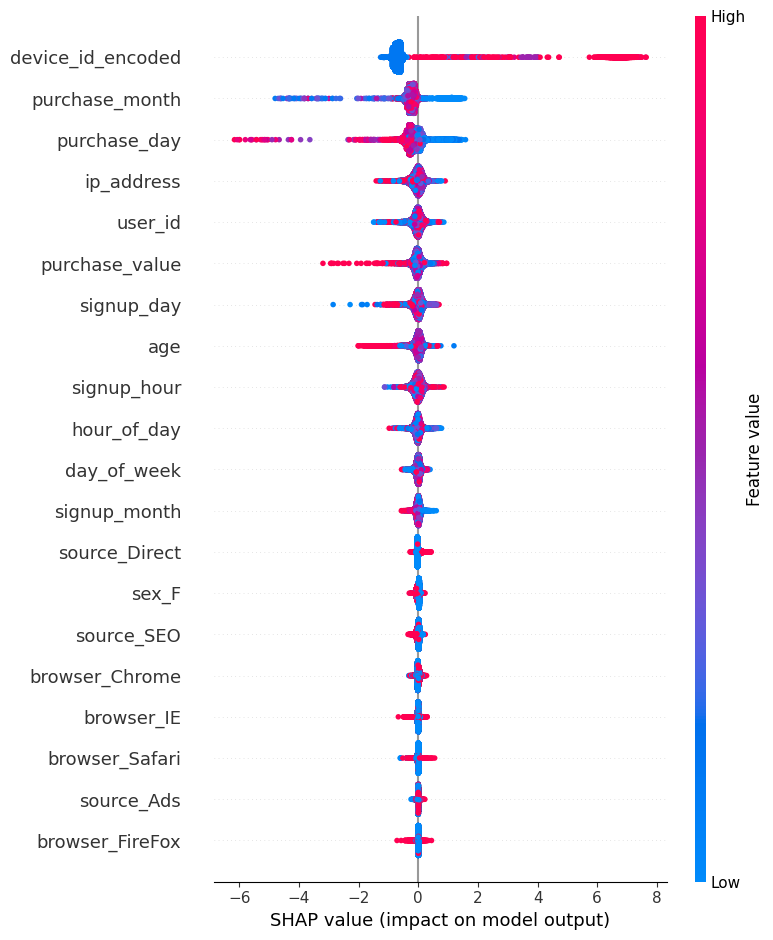

In [41]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_fraud)

# Plot the feature importance
shap.summary_plot(shap_values, X_test_fraud, feature_names=feature_names)

### SHAP Summary Plot Analysis

- **Feature Importance**: 
  - Ordered by importance: `device_id_encoded`, `purchase_month`, `purchase_day`, etc.
  
- **Impact on Model Output**:
  - **Positive/Negative Impact**: Positive SHAP values push towards fraud, negative towards non-fraud.
  - **High Impact Features**: `device_id_encoded`, `purchase_month`, `purchase_day` significantly influence predictions.

- **Distribution of Impact**:
  - Dots represent individual SHAP values; color indicates feature value (low to high).
  - E.g., `purchase_month` - higher values (red) increase fraud prediction.

- **Feature Interaction**: 
  - Spread of dots shows interaction. `age` has less variability compared to `device_id_encoded`.

- **Categorical Features**: 
  - Binary features like `source_Direct`, `browser_Chrome` show category influence. `browser_Firefox` slightly increases fraud prediction.

- **Model Interpretation**: 
  - Focuses on which features drive fraud/non-fraud predictions, notably `ip_address`.

### Actionable Insights

- **Prioritize**: `device_id_encoded`, `purchase_month`, `purchase_day`, `ip_address` for further analysis.
- **Feature Engineering**: Enhance these key features.
- **Model Validation**: Check for overfitting on `device_id_encoded`.
- **Behavior Analysis**: Investigate user behavior patterns from `purchase_value`, `signup_day`, and categorical features.

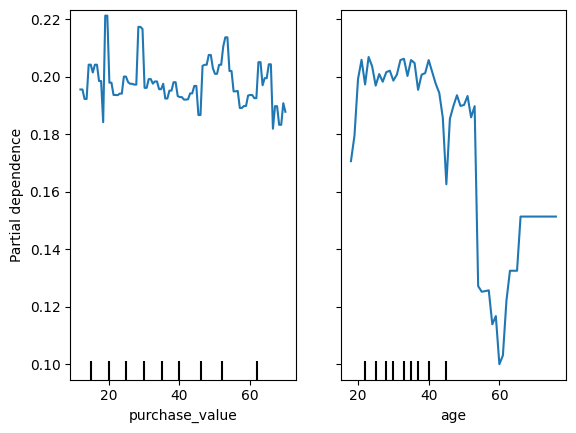

In [44]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(model, X_train_fraud, features=['purchase_value', 'age'], feature_names=feature_names)

In [45]:
from lime.lime_tabular import LimeTabularExplainer

# Assuming your data is tabular
explainer = LimeTabularExplainer(X_train_fraud.values, 
                                 feature_names=feature_names, 
                                 class_names=['Non-Fraud', 'Fraud'], 
                                 mode='classification')

In [47]:
# Choose an instance from your test set
instance_to_explain = X_test_fraud.iloc[0].values  # Adjust index as needed

# Get the explanation
exp = explainer.explain_instance(instance_to_explain, model.predict_proba, num_features=10)

In [48]:
# Show the explanation in a graphical format
exp.show_in_notebook(show_table=True, show_all=False)

# Or save as an HTML file
exp.save_to_file('lime_explanation.html')

In [49]:
# notebooks/fraud_analysis.ipynb
import pandas as pd
fraud_data = pd.read_csv('../data/Fraud_Data.csv')